In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim

from modal.BigModal import SubToSeq
from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, Timer, Average
useCuda = True
Variable = Variable.cuda if useCuda else Variable

ImportError: No module named 'modal'

In [2]:
import torch.utils.data
import pickle
with open("./translate/eng_fra_dataset", 'rb') as f:
    trainset = pickle.load(f)
    
loader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=2)

In [1]:
from dataset.translate import TranslateDataset as DramaDataset
datasets = DramaDataset(basedir="./translate/eng_fra_dataset",
                        maxFrame=0,
                        timeOffset=0.2,
                        startSeries=1,
                        maxSeries=5,
                        subOffset=0, 
                        subMax=200)

In [2]:
datasets[0]

('j ai demande a maintes reprises aux villageois de me laisser mourir .',
 'i asked the villagers many times to let me die .',
 [])

In [13]:
ModalFile = "TransModal/overtrain/"
modal = torch.load(ModalFile+"SubSubModal.180.pth")
with open(ModalFile+"Lang.pkl", 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModalFile, len(lang)))

Load lang model: TransModal/overtrain/. Word size: 32107


In [14]:
def transData(in_sents, target_sents, lang):
    in_seqs = []
    in_targets = []
    out_targets = []
    
    vectorTransforms = [torch.LongTensor, Variable]
    
    for sent in in_sents:
        in_seqs.append(lang.sentenceToVector(sent, sos=False, eos=False))
    in_seqs = padding(in_seqs, lang["PAD"], vectorTransforms)
    
    for sent in target_sents:
        in_targets.append(lang.sentenceToVector(sent, sos=True, eos=False))
        out_targets.append(lang.sentenceToVector(sent, sos=False, eos=True))
    in_targets = padding(in_targets, lang["PAD"], vectorTransforms)
    out_targets = padding(out_targets, lang["PAD"], vectorTransforms)
    return in_seqs, in_targets, out_targets

In [15]:
def predit(modal, lang, in_sents, max_length=50):
    ans = []
    in_seq = Variable(torch.LongTensor(lang.sentenceToVector(in_sents, sos=False, eos=False)).unsqueeze(0))
    inputs = Variable(torch.LongTensor([[lang["SOS"]]]).long())
    hidden = None
    
    cxt = modal.makeContext(in_seq)
    for i in range(max_length):
        outputs, hidden = modal.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        outputs = outputs[0][0].data[0]
        if(outputs == lang["EOS"]):
            break
        ans.append(outputs)
        inputs = Variable(torch.LongTensor([[outputs]]))
    return lang.vectorToSentence(ans)

In [16]:
import matplotlib.pyplot as plt
def showVar(data):
    x = range(0, data.size(-1))
    plt.bar(x, data.data.cpu())
    plt.show()

In [17]:
it = iter(loader)

In [23]:
fras, engs = it.next()

In [24]:
modal.eval()
for fra, eng in zip(fras, engs):
    pred = predit(modal, lang, fra)
    print("Fra: {}\nEng: {}\nPre: {}\n\n".format(fra, eng, pred))

Fra: sors de ma chambre immediatement .
Eng: leave my room immediately .
Pre: get out of my PAD right .


Fra: leur fille est infirmiere .
Eng: their daughter is a nurse .
Pre: their daughter is a nurse .


Fra: verifie !
Eng: check it out !
Pre: come on .


Fra: le monde est il devenu fou ?
Eng: has the world gone mad ?
Pre: has the world big become ?


Fra: qui etes vous et que voulez vous ?
Eng: who are you and what do you want ?
Pre: who are you and what do you want ?




In [30]:
in_seq = Variable(torch.LongTensor(lang.sentenceToVector(fras[1], sos=False, eos=False)).unsqueeze(0))
inputs = Variable(torch.LongTensor([[lang["SOS"]]]).long())
hidden = None

cxt = modal.makeContext(in_seq)

In [31]:
outputs, hidden = modal.decode(inputs, cxt, hidden)

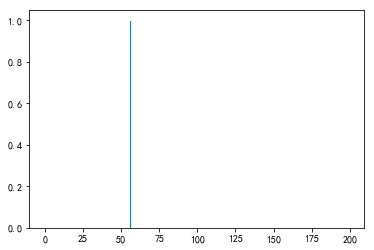

In [32]:
showVar(outputs[0,0,2000:2200])

In [33]:
outputs.topk(3)

(Variable containing:
 (0 ,.,.) = 
   0.9976  0.0022  0.0001
 [torch.cuda.FloatTensor of size 1x1x3 (GPU 0)], Variable containing:
 (0 ,.,.) = 
   2056   457   222
 [torch.cuda.LongTensor of size 1x1x3 (GPU 0)])